In [1]:
import sys 
import os
#import pandahelper as pdh


import cymetric as cym
import pandas as pd

import numpy as np
import sklearn as skl
from sklearn import datasets
import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl


In [2]:
file = "u_model.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)

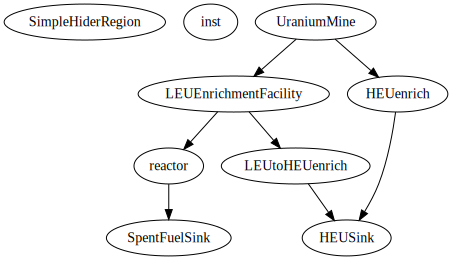

In [3]:
cym.graphs.flow_graph(ev)

In [4]:
agentTable = ev.eval("AgentEntry")
#print(type(agentTable))
#print(agentTable)
agents = agentTable.loc[:, ["AgentId", "Prototype"]]
print(agents)

transTable = ev.eval("Transactions")
transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
print(transactions)
print (transactions['ReceiverId'].unique())
    
resourceTable = ev.eval("Resources")
resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
print(resources)

   AgentId              Prototype
0       15      SimpleHiderRegion
1       16                   inst
2       17            UraniumMine
3       18  LEUEnrichmentFacility
4       19                reactor
5       20          SpentFuelSink
6       21              HEUenrich
7       22         LEUtoHEUenrich
8       23                HEUSink
     SenderId  ReceiverId  ResourceId Commodity  Time
0          17          18          14    c_uore     0
1          17          21          16    c_uore     0
2          18          19          35     c_leu     1
3          18          19          41     c_leu     1
4          18          19          47     c_leu     1
..        ...         ...         ...       ...   ...
513        21          23        3363     c_heu   142
514        22          23        3366     c_heu   142
515        17          21        3378    c_uore   143
516        18          22        3381     c_leu   143
517        21          23        3387     c_heu   143

[518 rows x

In [9]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    #print(type(agentTable))
    #print(agentTable)
    agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    #print(agents)
    
    transTable = ev.eval("Transactions")
    transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    #print(transactions)
    
    resourceTable = ev.eval("Resources")
    resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    #resources
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')
    #int1
    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})
    #int2 = pd.merge(int1, send, on = "SenderId", how = "inner")
    #int3 = pd.merge(int2, receive, on = "ReceiverId", how = "inner")

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
    int1
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

    
    return int1
    #tidy = spread(int1)
    #return tidy

def spread(df):
    #conceal commodity transactions
    material = [] 
    print(df["Commodity"].size)
    for row in df["Commodity"]:
        #print (row)
        if row == "c_uore":
            material.append("ore")
        if row == "c_leu" or row == "c_heu":
            material.append("fuel")
        if row == "c_spent_leu":
            material.append("spent")
    print(len(material))
    df["material"] = material
    
    int2 = df[["Time", "Quantity", "material"]]
    
    return int2
    #merge back indexed by time
    
    

In [10]:
tidy_data = tidy_df("u_model.sqlite")
print(tidy_data)

                  SenderId             ReceiverId  ResourceId Commodity  Time  \
0              UraniumMine  LEUEnrichmentFacility          14    c_uore     0   
1              UraniumMine              HEUenrich          16    c_uore     0   
2    LEUEnrichmentFacility                reactor          35     c_leu     1   
3    LEUEnrichmentFacility                reactor          41     c_leu     1   
4    LEUEnrichmentFacility                reactor          47     c_leu     1   
..                     ...                    ...         ...       ...   ...   
513              HEUenrich                HEUSink        3363     c_heu   142   
514         LEUtoHEUenrich                HEUSink        3366     c_heu   142   
515            UraniumMine              HEUenrich        3378    c_uore   143   
516  LEUEnrichmentFacility         LEUtoHEUenrich        3381     c_leu   143   
517              HEUenrich                HEUSink        3387     c_heu   143   

           Quantity  
0    

In [27]:
#rename facilities and mask material 
#1) assume all of the enrichment happens in one building 

tidy_data["SenderId"] = ["Enrichment" for row in tidy_data["SenderId"] if "nrich" in row]
#print(tidy_df)
type(tidy_data["SenderId"])

ValueError: Length of values does not match length of index